SF. Модуль 8. Проект 7. Ford vs Ferrari: определяем модель авто по фото

In [2]:
%%capture
!pip install wandb

In [3]:
#Подгрузаем библиотеки
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.compat.v1.keras import backend as K
from PIL import Image
import cv2
import albumentations as A


from sklearn.model_selection import train_test_split
from skimage import io, transform
from skimage.transform import AffineTransform, warp
from sklearn.metrics import roc_auc_score, mean_absolute_error, accuracy_score


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from pathlib import Path
import os
import zipfile
import random
import glob
import math

USE_WANDB = False
RANDOM_SEED = 4444


def seed_everything(seed=4444):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    
    
seed_everything(RANDOM_SEED)
from tensorflow.random import set_seed
set_seed(RANDOM_SEED)

In [4]:
import wandb
from wandb.keras import WandbCallback

if USE_WANDB:
    CURRENT_TIME = str(datetime.datetime.now()).replace(' ', '_').split('.')[0]
    RUN_NAME = 'EfficientNetB5'

    wandb.login()
    run = wandb.init(project="keras-car-classification", name = f'{RUN_NAME}_{CURRENT_TIME}')

In [5]:
DATA_PATH = '../input/sf-dl-car-classification/'
PATH = "./working/"

EDA. Модель

In [6]:
train_df = pd.read_csv(DATA_PATH + "train.csv")
sample_submission = pd.read_csv(DATA_PATH + "sample-submission.csv")
train_df.head()

,Id,Category
0,100155.jpg,0
1,100306.jpg,0
2,100379.jpg,0
3,100380.jpg,0
4,100389.jpg,0


In [7]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15561 entries, 0 to 15560
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Id        15561 non-null  object
 1   Category  15561 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 243.3+ KB


In [8]:
train_df.Category.value_counts()

1    1971
8    1765
6    1733
5    1631
0    1613
3    1528
2    1458
4    1400
9    1255
7    1207
Name: Category, dtype: int64

In [9]:
# Разархивируем папку с картинками машин
for data_zip in ['train.zip', 'test.zip']:
    with zipfile.ZipFile(DATA_PATH + data_zip, 'r') as zip_file:
        zip_file.extractall(PATH)
        
print(os.listdir(PATH))

['test_upload', 'train']


Image examples (random sample):


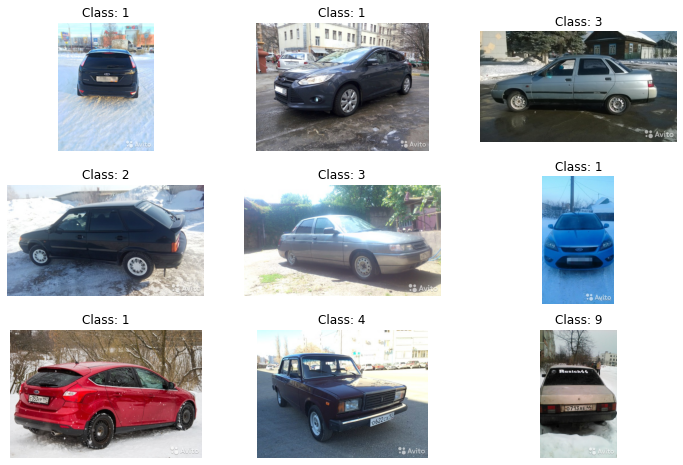

In [10]:
print('Image examples (random sample):')
plt.figure(figsize=(12,8))

random_image = train_df.sample(n=9)
random_image_paths = random_image['Id'].values
random_image_cat = random_image['Category'].values


for index, path in enumerate(random_image_paths):
    im = Image.open(PATH + f'train/{random_image_cat[index]}/{path}')
    plt.subplot(3, 3, index + 1)
    plt.imshow(im)
    plt.title('Class: ' + str(random_image_cat[index]))
    plt.axis('off')
plt.show()

Приведем картинки к единому размеру

In [11]:
# Класс с некоторыми константами и методами аугментации
class Config:
    BATCH_SIZE = 32
    TRAINING_EPOCHS = 15
    VALIDATION_STEPS_PER_EPOCH = 5
    VALIDATION_EPOCHS = 10
    STEPS_PER_EPOCH = 200
    EARLY_STOP_PATIENCE = 5
    NUM_CLASSES = 10
    INPUT_SHAPE = 256, 256, 3
    LR = 1e-4
    
    
    # Определим пайплайн для агументации
    train_transform = A.Compose([
        A.HorizontalFlip(p=0.5),
        A.Cutout(num_holes=8, max_h_size=8, max_w_size=8, p=0.3),
        A.OneOf([A.RandomContrast(),
                 A.RandomGamma(),
                 A.RandomBrightness(),
                 A.RGBShift()],p=0.3),
        A.OneOf([A.Blur(p=0.3),
                 A.GaussNoise(p=0.3)],p=0.3),
        A.OneOf([A.RandomRain(p=0.2),
                 A.RandomSnow(p=0.2),
                 A.RandomSunFlare(p=0.2),
                 A.ChannelShuffle(p=0.2)], p=0.3),
        A.CLAHE(clip_limit=4, tile_grid_size=(8,8), always_apply=False, p=0.3),
        ],)
    
    validation_transform = A.Compose([
    ],)

In [12]:
# Объедини данные
train_data, val_data = train_test_split(train_df, 
                                        test_size=0.15,
                                        shuffle=True, 
                                        stratify=train_df['Category'],
                                        random_state=RANDOM_SEED)
train_data = train_data.reset_index(drop=True)
val_data = val_data.reset_index(drop=True)

In [13]:
# Генерация данных
class DataGenerator(tf.keras.utils.Sequence):
    def __init__(self, transform=None, batch_size=Config.BATCH_SIZE,
                 shuffle=True, is_classification=True, augment=False,
                 x_col='Id', y_col='Category', df=train_data,
                 num_classes=Config.NUM_CLASSES, path=PATH + 'train'):
        # Data info
        self.indices = df.index.tolist()
        self.transform = transform
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.augment = augment
        self.is_classification = is_classification
        self.x_col = x_col
        self.y_col = y_col
        self.df = df
        self.num_classes = num_classes
        self.image_size = Config.INPUT_SHAPE[:2]
        self.path = path
        
        self.on_epoch_end()

    def __len__(self):
        # Number of batches per epoch
        return len(self.indices) // self.batch_size

    def __getitem__(self, index):
        # Generating batch indices
        index = self.index[index * self.batch_size:(index + 1) * self.batch_size]
        # Indices list for a batch
        batch = [self.indices[k] for k in index]
    
        X, y = self.__get_data(batch)
        return X, y

    def on_epoch_end(self):
        # Updating indices after each epoch
        self.index = np.arange(len(self.indices))
        if self.shuffle:
            np.random.shuffle(self.index)

    def __get_data(self, batch=None):
        # Generating the data containing batch_size samples
        random_images = self.df.iloc[batch]
        random_names = random_images[self.x_col].values
        random_cats = random_images[self.y_col].values
        X = np.zeros((self.batch_size, 256, 256, 3))
        y = np.zeros((self.batch_size,))

        for idx, image in enumerate(random_names):
            cat = random_cats[idx]
            image = Image.open(f'{self.path}/{cat}/{image}')
            image = np.asarray(image.resize((256, 256)))
            if len(image.shape) < 3:
                image = image.reshape((256, 256, 1))
                image = np.concatenate([image, image, image], axis=2)
            X[idx, ] = image
            y[idx] = cat
            
            if self.augment:
                X[idx, ] = Config.train_transform(image=X[idx, ].astype(np.uint8))['image']
                

        y = tf.keras.utils.to_categorical(y, self.num_classes)
            
        return X / 255.0, y

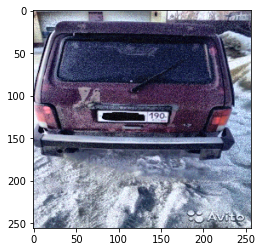

In [14]:
# Генерация данных для успешной проверки
train_datagen = DataGenerator(batch_size=Config.BATCH_SIZE,
                              is_classification=True,
                              df=train_data,
                              augment=True)
val_datagen = DataGenerator(batch_size=Config.BATCH_SIZE,
                            is_classification=True,
                            df=val_data,
                            augment=False)
# Извлечение данных
X_train, y_train = train_datagen.__getitem__(0)
X_val, y_val = val_datagen.__getitem__(0)

for im in X_train:
    plt.imshow(im)
    break

Построим модель

In [15]:
import tensorflow as tf
from keras import layers as L
from keras.models import Model
import keras

from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import LearningRateScheduler, ModelCheckpoint, EarlyStopping
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.applications.densenet import DenseNet121

from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications import EfficientNetB5
from tensorflow.keras.applications import EfficientNetB6
from tensorflow.keras.applications import EfficientNetB7
from tensorflow.keras.applications import Xception

In [16]:
K.clear_session()

In [17]:
# LR Scheduler. Убывание по экспоненте
def exp_decay(epoch):
    initial_lrate=Config.LR
    k = 0.1
    lrate = initial_lrate * exp(-k*t)
    return lrate

# шаг распада
def step_decay(epoch):
    initial_lrate = 0.1
    drop = 0.5
    epochs_drop = 10.0
    lrate = initial_lrate * math.pow(drop,  
           math.floor((1+epoch)/epochs_drop))
    return lrate


lrate = LearningRateScheduler(exp_decay)


# История потерь
class LossHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.losses=[]
        self.lr = []
        
    def on_epoch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))
        self.lr.append(exp_decay(len(self.losses)))
        
        
loss_history = LossHistory()

In [18]:
# Добавление контрольной точки и ранняя остановка
checkpoint = ModelCheckpoint('best_model.hdf5', save_best_only=True,
                             monitor=['val_accuracy'], verbose=1, mode='max')
earlystop = EarlyStopping(monitor='val_loss', patience=Config.EARLY_STOP_PATIENCE)

# В качестве базовой модели мы берем SOTA но не самую глубокую, чтобы сэкономить некоторое время
base_model_enb5 = EfficientNetB5(weights='imagenet',
                            input_shape=(256, 256, 3),
                            include_top=False)
base_model_xcp = Xception(weights='imagenet',
                      input_shape=(256, 256, 3),
                      include_top=False)
# Список базовых моделей
base_models = [base_model_enb5, base_model_xcp]

    
def create_classification_model(base_model, trainable=True):
    x = base_model.output
    x = L.GlobalAveragePooling2D()(x)
    # let's add a fully-connected layer
    x = L.Dense(512)(x)
    x = L.BatchNormalization()(x)
    x = L.Activation('relu')(x)
    x = L.Dropout(0.25)(x)
    x = L.Dense(256)(x)
    x = L.BatchNormalization()(x)
    x = L.Activation('relu')(x)
    x = L.Dropout(0.25)(x)
    x = L.Dense(128)(x)
    x = L.BatchNormalization()(x)
    x = L.Activation('relu')(x)
    x = L.Dropout(0.25)(x)
    predictions = L.Dense(Config.NUM_CLASSES, activation='softmax')(x)

    # Обучаем эту модель
    model = Model(inputs=base_model.input, outputs=predictions)
    
    # Установка слоев базовой модели на необучаемые
    if not trainable:
        for layer in base_model.layers:
            layer.trainable = False

    # скомпилируем модель 
    model.compile(optimizer=tf.keras.optimizers.Adam(lr=Config.LR), 
                  loss='categorical_crossentropy', 
                  metrics = ['accuracy'])
    return model

Exception: URL fetch failure on https://storage.googleapis.com/keras-applications/efficientnetb5_notop.h5: None -- [Errno -3] Temporary failure in name resolution

In [ ]:
# Обучение модели
if USE_WANDB:
    history = model.fit(
                        train_datagen, 
                        steps_per_epoch = Config.STEPS_PER_EPOCH, 
                        validation_data = val_datagen, 
                        validation_steps = len(val_datagen),
                        epochs = Config.TRAINING_EPOCHS,
                        verbose = 1,
                        callbacks = [checkpoint, earlystop, WandbCallback()]
                        )
else:
    history = model.fit(
                        train_datagen, 
                        steps_per_epoch = Config.STEPS_PER_EPOCH, 
                        validation_data = val_datagen, 
                        validation_steps = len(val_datagen),
                        epochs = Config.TRAINING_EPOCHS,
                        verbose = 1,
                        callbacks = [checkpoint, earlystop]
                        )

In [ ]:
if USE_WANDB:
    run.finish()

In [ ]:
# Сохраняем
model.save('../working/model_last.hdf5')
model.load_weights('best_model.hdf5')

In [ ]:
scores = model.evaluate(val_datagen, steps=len(val_datagen), verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

In [ ]:
# Построим график потерь во время тренировки
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
 
epochs = range(len(acc))
 
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
 
plt.figure()
 
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
 
plt.show()

Делаем предсказания на основе модели

In [ ]:
test_datagen = ImageDataGenerator(rescale=1. / 255)

test_sub_generator = test_datagen.flow_from_dataframe( 
    dataframe=sample_submission,
    directory=PATH+'test_upload/',
    x_col="Id",
    y_col=None,
    shuffle=False,
    class_mode=None,
    seed=RANDOM_SEED,
    target_size=(256, 256),
    batch_size=Config.BATCH_SIZE)

In [ ]:
test_sub_generator.reset()
predictions = model.predict(test_sub_generator, steps=len(test_sub_generator), verbose=1) 
predictions = np.argmax(predictions, axis=-1)

In [ ]:
filenames_with_dir = test_sub_generator.filenames
submission = pd.DataFrame({'Id':filenames_with_dir, 'Category': predictions}, columns=['Id', 'Category'])
submission['Id'] = submission['Id'].replace('test_upload/','')
submission.to_csv('submission.csv', index=False)
print('Save submit')

In [ ]:
submission